In [4]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#This file is for development. Main functions are embedded here.

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Settings for pattern mining
timerange=(5,25) #in minutes
peakwidth=0.25 #in minutes
interval=0.5 #
slope_filter=(0.5,2) # normalized slope (1=true)
correlation=0.7 #minimum r-squared correlation cut-off. 

mass_tolerance=0.001
ratio_tolerance=1.3

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters

import matplotlib.backends.backend_pdf

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -2
MSParameters.molecular_search.max_ppm_error = 2

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
#MSParameters.molecular_search.usedAtoms['S'] = (0,0)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

In [5]:
#Read in sample list and load MS data

samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')

MSfiles={}
for file in samplelist['File'][samplelist['type']=='sample']:
#for file in samplelist.File:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

print(samplelist)

samplelist=samplelist[samplelist['File'].isin(MSfiles.keys())]

                            File          type  run order  Sample number  \
0     RMB_190828_BATS01_100m.raw  other_sample          4            1.0   
1       RMB_190828_BATS02_5m.raw  other_sample          5            2.0   
2       RMB_190828_BATS03_5m.raw  other_sample          6            3.0   
3     RMB_190828_BATS04_250m.raw  other_sample          7            4.0   
4     RMB_190828_BATS05_300m.raw        sample          8            5.0   
5     RMB_190828_BATS06_400m.raw        sample          9            6.0   
6     RMB_190828_BATS07_500m.raw        sample         10            7.0   
7     RMB_190828_BATS08_100m.raw        sample         11            8.0   
8     RMB_190828_BATS09_200m.raw        sample         13            9.0   
9     RMB_190828_BATS10_800m.raw        sample         14           10.0   
10   RMB_190828_BATS11_1000m.raw        sample         15           11.0   
11      RMB_190828_BATS12_5m.raw        sample         16           12.0   
12     RMB_1

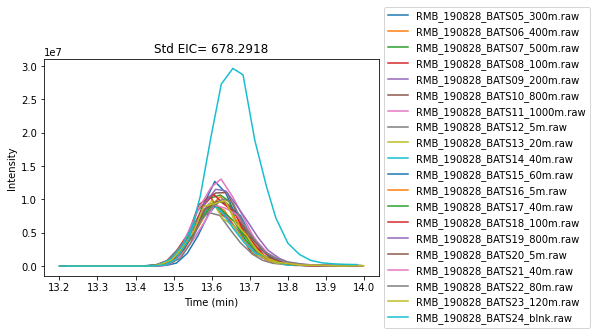

19
pass of
20
12.3 % std dev


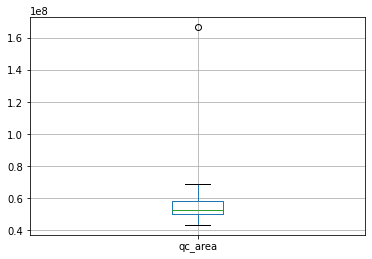

In [4]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

In [8]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=4
timerange=[2,28]


def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()
        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        AverageMS = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum=AverageMS
        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [9]:
#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

RMB_190828_BATS05_300m.raw
'runworker'  34.41 ms


Loading molecular formula database: 84098it [00:06, 12121.83it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 101.87it/s]


'run_molecular_formula'  8047.48 ms
420 assigned peaks and 132 unassigned peaks, total  = 76.09 %, relative abundance = 71.23 %, RMS error (best candidate) (ppm) = 0.717
'runworker'  34.32 ms


Loading molecular formula database: 84098it [00:06, 12141.56it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.97it/s]


'run_molecular_formula'  8394.46 ms
727 assigned peaks and 90 unassigned peaks, total  = 88.98 %, relative abundance = 90.40 %, RMS error (best candidate) (ppm) = 0.703
'runworker'  33.71 ms


Loading molecular formula database: 84098it [00:07, 11728.27it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.51it/s]


'run_molecular_formula'  8907.90 ms
915 assigned peaks and 90 unassigned peaks, total  = 91.04 %, relative abundance = 93.89 %, RMS error (best candidate) (ppm) = 0.750
'runworker'  36.66 ms


Loading molecular formula database: 84098it [00:08, 9774.38it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.26it/s]


'run_molecular_formula'  10649.10 ms
1127 assigned peaks and 90 unassigned peaks, total  = 92.60 %, relative abundance = 95.86 %, RMS error (best candidate) (ppm) = 0.840
'runworker'  36.40 ms


Loading molecular formula database: 84098it [00:07, 10609.10it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.52it/s]


'run_molecular_formula'  10037.66 ms
1171 assigned peaks and 94 unassigned peaks, total  = 92.57 %, relative abundance = 96.15 %, RMS error (best candidate) (ppm) = 0.834
'runworker'  35.33 ms


Loading molecular formula database: 84098it [00:08, 9487.25it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.77it/s]


'run_molecular_formula'  11386.86 ms
1250 assigned peaks and 230 unassigned peaks, total  = 84.46 %, relative abundance = 92.46 %, RMS error (best candidate) (ppm) = 0.821
'runworker'  347.82 ms


Loading molecular formula database: 84098it [00:09, 9207.97it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


'run_molecular_formula'  14077.83 ms
1302 assigned peaks and 4291 unassigned peaks, total  = 23.28 %, relative abundance = 52.53 %, RMS error (best candidate) (ppm) = 0.905
RMB_190828_BATS06_400m.raw
'runworker'  380.19 ms


Loading molecular formula database: 84098it [00:07, 11375.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 98.52it/s]


'run_molecular_formula'  8889.54 ms
484 assigned peaks and 114 unassigned peaks, total  = 80.94 %, relative abundance = 78.15 %, RMS error (best candidate) (ppm) = 0.787
'runworker'  37.89 ms


Loading molecular formula database: 84098it [00:06, 13250.63it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.35it/s]


'run_molecular_formula'  7826.50 ms
765 assigned peaks and 89 unassigned peaks, total  = 89.58 %, relative abundance = 91.42 %, RMS error (best candidate) (ppm) = 0.734
'runworker'  36.18 ms


Loading molecular formula database: 84098it [00:08, 10161.73it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.15it/s]


'run_molecular_formula'  10033.21 ms
951 assigned peaks and 93 unassigned peaks, total  = 91.09 %, relative abundance = 94.70 %, RMS error (best candidate) (ppm) = 0.753
'runworker'  37.30 ms


Loading molecular formula database: 84098it [00:07, 10974.55it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.41it/s]


'run_molecular_formula'  9780.57 ms
1207 assigned peaks and 114 unassigned peaks, total  = 91.37 %, relative abundance = 95.84 %, RMS error (best candidate) (ppm) = 0.843
'runworker'  34.37 ms


Loading molecular formula database: 84098it [00:08, 9819.98it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 50.70it/s]


'run_molecular_formula'  10720.99 ms
1198 assigned peaks and 89 unassigned peaks, total  = 93.08 %, relative abundance = 96.73 %, RMS error (best candidate) (ppm) = 0.850
'runworker'  36.10 ms


Loading molecular formula database: 84098it [00:08, 10158.12it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.06it/s]


'run_molecular_formula'  10669.26 ms
1203 assigned peaks and 124 unassigned peaks, total  = 90.66 %, relative abundance = 94.69 %, RMS error (best candidate) (ppm) = 0.832
'runworker'  47.00 ms


Loading molecular formula database: 84098it [00:09, 8605.01it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:04<00:00, 21.60it/s]


'run_molecular_formula'  14625.07 ms
1354 assigned peaks and 4380 unassigned peaks, total  = 23.61 %, relative abundance = 56.22 %, RMS error (best candidate) (ppm) = 0.933
RMB_190828_BATS07_500m.raw
'runworker'  36.85 ms


Loading molecular formula database: 84098it [00:06, 13600.94it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 107.63it/s]


'run_molecular_formula'  7234.43 ms
413 assigned peaks and 124 unassigned peaks, total  = 76.91 %, relative abundance = 72.21 %, RMS error (best candidate) (ppm) = 0.735
'runworker'  299.03 ms


Loading molecular formula database: 84098it [00:07, 11400.27it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 72.41it/s]


'run_molecular_formula'  9188.61 ms
771 assigned peaks and 112 unassigned peaks, total  = 87.32 %, relative abundance = 90.92 %, RMS error (best candidate) (ppm) = 0.739
'runworker'  35.83 ms


Loading molecular formula database: 84098it [00:07, 10905.50it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.44it/s]


'run_molecular_formula'  9481.99 ms
953 assigned peaks and 73 unassigned peaks, total  = 92.88 %, relative abundance = 95.25 %, RMS error (best candidate) (ppm) = 0.769
'runworker'  37.75 ms


Loading molecular formula database: 84098it [00:07, 11104.71it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 57.70it/s]


'run_molecular_formula'  9498.33 ms
1080 assigned peaks and 69 unassigned peaks, total  = 93.99 %, relative abundance = 96.70 %, RMS error (best candidate) (ppm) = 0.842
'runworker'  37.81 ms


Loading molecular formula database: 84098it [00:09, 9184.18it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.23it/s]


'run_molecular_formula'  11554.06 ms
1366 assigned peaks and 138 unassigned peaks, total  = 90.82 %, relative abundance = 96.28 %, RMS error (best candidate) (ppm) = 0.869
'runworker'  35.33 ms


Loading molecular formula database: 84098it [00:09, 9029.78it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


'run_molecular_formula'  12023.57 ms
1373 assigned peaks and 254 unassigned peaks, total  = 84.39 %, relative abundance = 92.88 %, RMS error (best candidate) (ppm) = 0.854
'runworker'  37.02 ms


Loading molecular formula database: 84098it [00:08, 9598.67it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


'run_molecular_formula'  13449.42 ms
1296 assigned peaks and 4430 unassigned peaks, total  = 22.63 %, relative abundance = 53.39 %, RMS error (best candidate) (ppm) = 0.917
RMB_190828_BATS08_100m.raw
'runworker'  365.58 ms


Loading molecular formula database: 84098it [00:07, 11579.74it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 97.39it/s]


'run_molecular_formula'  8770.59 ms
384 assigned peaks and 191 unassigned peaks, total  = 66.78 %, relative abundance = 62.72 %, RMS error (best candidate) (ppm) = 0.768
'runworker'  36.04 ms


Loading molecular formula database: 84098it [00:06, 12027.80it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 76.00it/s]


'run_molecular_formula'  8443.93 ms
724 assigned peaks and 124 unassigned peaks, total  = 85.38 %, relative abundance = 88.06 %, RMS error (best candidate) (ppm) = 0.761
'runworker'  36.10 ms


Loading molecular formula database: 84098it [00:07, 11000.26it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.77it/s]


'run_molecular_formula'  9308.16 ms
899 assigned peaks and 104 unassigned peaks, total  = 89.63 %, relative abundance = 93.52 %, RMS error (best candidate) (ppm) = 0.758
'runworker'  37.55 ms


Loading molecular formula database: 84098it [00:08, 10287.70it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 59.64it/s]


'run_molecular_formula'  10014.89 ms
1013 assigned peaks and 86 unassigned peaks, total  = 92.17 %, relative abundance = 94.97 %, RMS error (best candidate) (ppm) = 0.829
'runworker'  33.51 ms


Loading molecular formula database: 84098it [00:08, 10462.85it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.17it/s]


'run_molecular_formula'  10093.61 ms
1113 assigned peaks and 73 unassigned peaks, total  = 93.84 %, relative abundance = 95.91 %, RMS error (best candidate) (ppm) = 0.863
'runworker'  34.50 ms


Loading molecular formula database: 84098it [00:08, 9386.40it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.32it/s]


'run_molecular_formula'  11399.20 ms
1215 assigned peaks and 152 unassigned peaks, total  = 88.88 %, relative abundance = 93.82 %, RMS error (best candidate) (ppm) = 0.848
'runworker'  37.44 ms


Loading molecular formula database: 84098it [00:10, 8044.81it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 19.22it/s]


'run_molecular_formula'  15882.81 ms
1643 assigned peaks and 4699 unassigned peaks, total  = 25.91 %, relative abundance = 57.74 %, RMS error (best candidate) (ppm) = 0.959
RMB_190828_BATS09_200m.raw
'runworker'  37.96 ms


Loading molecular formula database: 84098it [00:06, 13284.49it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 102.33it/s]


'run_molecular_formula'  7429.63 ms
401 assigned peaks and 151 unassigned peaks, total  = 72.64 %, relative abundance = 67.42 %, RMS error (best candidate) (ppm) = 0.766
'runworker'  33.79 ms


Loading molecular formula database: 84098it [00:07, 11455.12it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.36it/s]


'run_molecular_formula'  9074.28 ms
795 assigned peaks and 90 unassigned peaks, total  = 89.83 %, relative abundance = 91.40 %, RMS error (best candidate) (ppm) = 0.782
'runworker'  38.53 ms


Loading molecular formula database: 84098it [00:07, 10832.44it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.91it/s]


'run_molecular_formula'  9722.29 ms
1015 assigned peaks and 93 unassigned peaks, total  = 91.61 %, relative abundance = 95.09 %, RMS error (best candidate) (ppm) = 0.813
'runworker'  35.78 ms


Loading molecular formula database: 84098it [00:08, 10044.80it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.67it/s]


'run_molecular_formula'  10338.28 ms
1094 assigned peaks and 62 unassigned peaks, total  = 94.64 %, relative abundance = 96.85 %, RMS error (best candidate) (ppm) = 0.869
'runworker'  40.24 ms


Loading molecular formula database: 84098it [00:08, 9883.03it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


'run_molecular_formula'  10910.73 ms
1319 assigned peaks and 86 unassigned peaks, total  = 93.88 %, relative abundance = 97.17 %, RMS error (best candidate) (ppm) = 0.896
'runworker'  50.74 ms


Loading molecular formula database: 84098it [00:10, 8355.36it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.21it/s]


'run_molecular_formula'  12385.90 ms
1220 assigned peaks and 135 unassigned peaks, total  = 90.04 %, relative abundance = 94.35 %, RMS error (best candidate) (ppm) = 0.863
'runworker'  34.93 ms


Loading molecular formula database: 84098it [00:09, 8775.12it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


'run_molecular_formula'  14923.01 ms
1578 assigned peaks and 4723 unassigned peaks, total  = 25.04 %, relative abundance = 59.65 %, RMS error (best candidate) (ppm) = 0.974
RMB_190828_BATS10_800m.raw
'runworker'  35.63 ms


Loading molecular formula database: 84098it [00:06, 13038.28it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 98.38it/s]


'run_molecular_formula'  7593.84 ms
462 assigned peaks and 151 unassigned peaks, total  = 75.37 %, relative abundance = 68.37 %, RMS error (best candidate) (ppm) = 0.761
'runworker'  340.30 ms


Loading molecular formula database: 84098it [00:07, 11288.39it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 67.41it/s]


'run_molecular_formula'  9387.36 ms
863 assigned peaks and 98 unassigned peaks, total  = 89.80 %, relative abundance = 92.07 %, RMS error (best candidate) (ppm) = 0.794
'runworker'  34.24 ms


Loading molecular formula database: 84098it [00:07, 11487.18it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.67it/s]


'run_molecular_formula'  9276.00 ms
1094 assigned peaks and 79 unassigned peaks, total  = 93.27 %, relative abundance = 95.70 %, RMS error (best candidate) (ppm) = 0.836
'runworker'  35.46 ms


Loading molecular formula database: 84098it [00:08, 9788.54it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.55it/s]


'run_molecular_formula'  10788.55 ms
1266 assigned peaks and 80 unassigned peaks, total  = 94.06 %, relative abundance = 97.11 %, RMS error (best candidate) (ppm) = 0.917
'runworker'  35.29 ms


Loading molecular formula database: 84098it [00:08, 10250.47it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.11it/s]


'run_molecular_formula'  10552.56 ms
1374 assigned peaks and 68 unassigned peaks, total  = 95.28 %, relative abundance = 97.66 %, RMS error (best candidate) (ppm) = 0.926
'runworker'  34.71 ms


Loading molecular formula database: 84098it [00:08, 9453.13it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.74it/s]


'run_molecular_formula'  11484.38 ms
1312 assigned peaks and 230 unassigned peaks, total  = 85.08 %, relative abundance = 91.53 %, RMS error (best candidate) (ppm) = 0.882
'runworker'  35.12 ms


Loading molecular formula database: 84098it [00:09, 8875.13it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


'run_molecular_formula'  12524.61 ms
910 assigned peaks and 2295 unassigned peaks, total  = 28.39 %, relative abundance = 58.17 %, RMS error (best candidate) (ppm) = 0.934
RMB_190828_BATS11_1000m.raw
'runworker'  36.11 ms


Loading molecular formula database: 84098it [00:06, 12063.36it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 88.67it/s]


'run_molecular_formula'  8237.91 ms
502 assigned peaks and 155 unassigned peaks, total  = 76.41 %, relative abundance = 71.19 %, RMS error (best candidate) (ppm) = 0.797
'runworker'  37.62 ms


Loading molecular formula database: 84098it [00:06, 13005.05it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 68.41it/s]


'run_molecular_formula'  8109.30 ms
879 assigned peaks and 105 unassigned peaks, total  = 89.33 %, relative abundance = 92.31 %, RMS error (best candidate) (ppm) = 0.810
'runworker'  33.80 ms


Loading molecular formula database: 84098it [00:08, 10147.88it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.03it/s]


'run_molecular_formula'  10506.10 ms
1207 assigned peaks and 102 unassigned peaks, total  = 92.21 %, relative abundance = 95.40 %, RMS error (best candidate) (ppm) = 0.875
'runworker'  34.22 ms


Loading molecular formula database: 84098it [00:08, 9606.37it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.46it/s]


'run_molecular_formula'  11036.05 ms
1327 assigned peaks and 73 unassigned peaks, total  = 94.79 %, relative abundance = 97.40 %, RMS error (best candidate) (ppm) = 0.943
'runworker'  35.33 ms


Loading molecular formula database: 84098it [00:08, 9788.77it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.01it/s]


'run_molecular_formula'  11102.02 ms
1406 assigned peaks and 98 unassigned peaks, total  = 93.48 %, relative abundance = 96.91 %, RMS error (best candidate) (ppm) = 0.933
'runworker'  37.72 ms


Loading molecular formula database: 84098it [00:08, 9651.58it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


'run_molecular_formula'  11186.10 ms
1256 assigned peaks and 202 unassigned peaks, total  = 86.15 %, relative abundance = 91.25 %, RMS error (best candidate) (ppm) = 0.886
'runworker'  35.38 ms


Loading molecular formula database: 84098it [00:08, 9436.23it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


'run_molecular_formula'  12003.06 ms
849 assigned peaks and 2585 unassigned peaks, total  = 24.72 %, relative abundance = 53.48 %, RMS error (best candidate) (ppm) = 0.963
RMB_190828_BATS12_5m.raw
'runworker'  35.08 ms


Loading molecular formula database: 84098it [00:06, 12014.46it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.71it/s]


'run_molecular_formula'  8300.01 ms
486 assigned peaks and 127 unassigned peaks, total  = 79.28 %, relative abundance = 73.48 %, RMS error (best candidate) (ppm) = 0.831
'runworker'  36.61 ms


Loading molecular formula database: 84098it [00:07, 10605.59it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 59.16it/s]


'run_molecular_formula'  9791.31 ms
794 assigned peaks and 142 unassigned peaks, total  = 84.83 %, relative abundance = 86.09 %, RMS error (best candidate) (ppm) = 0.817
'runworker'  35.47 ms


Loading molecular formula database: 84098it [00:07, 10934.85it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 60.06it/s]


'run_molecular_formula'  9515.05 ms
913 assigned peaks and 99 unassigned peaks, total  = 90.22 %, relative abundance = 93.49 %, RMS error (best candidate) (ppm) = 0.824
'runworker'  35.67 ms


Loading molecular formula database: 84098it [00:08, 9597.22it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.45it/s]


'run_molecular_formula'  10806.71 ms
1130 assigned peaks and 89 unassigned peaks, total  = 92.70 %, relative abundance = 94.33 %, RMS error (best candidate) (ppm) = 0.899
'runworker'  33.34 ms


Loading molecular formula database: 84098it [00:07, 10519.36it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.12it/s]


'run_molecular_formula'  10212.04 ms
1235 assigned peaks and 109 unassigned peaks, total  = 91.89 %, relative abundance = 95.54 %, RMS error (best candidate) (ppm) = 0.915
'runworker'  38.87 ms


Loading molecular formula database: 84098it [00:09, 9266.54it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.17it/s]


'run_molecular_formula'  11696.09 ms
1348 assigned peaks and 190 unassigned peaks, total  = 87.65 %, relative abundance = 93.00 %, RMS error (best candidate) (ppm) = 0.912
'runworker'  358.44 ms


Loading molecular formula database: 84098it [00:10, 8234.68it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


'run_molecular_formula'  18392.28 ms
2458 assigned peaks and 5317 unassigned peaks, total  = 31.61 %, relative abundance = 69.12 %, RMS error (best candidate) (ppm) = 0.988
RMB_190828_BATS13_20m.raw
'runworker'  38.81 ms


Loading molecular formula database: 84098it [00:07, 10877.17it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 87.00it/s]


'run_molecular_formula'  9030.97 ms
469 assigned peaks and 221 unassigned peaks, total  = 67.97 %, relative abundance = 62.27 %, RMS error (best candidate) (ppm) = 0.832
'runworker'  38.68 ms


Loading molecular formula database: 84098it [00:07, 11630.12it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.43it/s]


'run_molecular_formula'  8903.85 ms
754 assigned peaks and 142 unassigned peaks, total  = 84.15 %, relative abundance = 84.56 %, RMS error (best candidate) (ppm) = 0.826
'runworker'  34.02 ms


Loading molecular formula database: 84098it [00:08, 9631.44it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.98it/s]


'run_molecular_formula'  10706.52 ms
1038 assigned peaks and 124 unassigned peaks, total  = 89.33 %, relative abundance = 93.40 %, RMS error (best candidate) (ppm) = 0.847
'runworker'  34.00 ms


Loading molecular formula database: 84098it [00:07, 10626.21it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.02it/s]


'run_molecular_formula'  9984.21 ms
1138 assigned peaks and 95 unassigned peaks, total  = 92.30 %, relative abundance = 94.15 %, RMS error (best candidate) (ppm) = 0.903
'runworker'  37.02 ms


Loading molecular formula database: 84098it [00:08, 9643.97it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.53it/s]


'run_molecular_formula'  11156.60 ms
1267 assigned peaks and 100 unassigned peaks, total  = 92.68 %, relative abundance = 95.83 %, RMS error (best candidate) (ppm) = 0.920
'runworker'  36.54 ms


Loading molecular formula database: 84098it [00:09, 9312.61it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.59it/s]


'run_molecular_formula'  11629.83 ms
1353 assigned peaks and 187 unassigned peaks, total  = 87.86 %, relative abundance = 92.41 %, RMS error (best candidate) (ppm) = 0.935
'runworker'  37.51 ms


Loading molecular formula database: 84098it [00:10, 8014.99it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


'run_molecular_formula'  17460.21 ms
2404 assigned peaks and 5201 unassigned peaks, total  = 31.61 %, relative abundance = 68.86 %, RMS error (best candidate) (ppm) = 0.997
RMB_190828_BATS14_40m.raw
'runworker'  41.98 ms


Loading molecular formula database: 84098it [00:07, 11598.98it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 87.40it/s]


'run_molecular_formula'  8546.56 ms
468 assigned peaks and 172 unassigned peaks, total  = 73.12 %, relative abundance = 66.96 %, RMS error (best candidate) (ppm) = 0.847
'runworker'  35.26 ms


Loading molecular formula database: 84098it [00:07, 10882.61it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.19it/s]


'run_molecular_formula'  9389.82 ms
822 assigned peaks and 166 unassigned peaks, total  = 83.20 %, relative abundance = 80.60 %, RMS error (best candidate) (ppm) = 0.833
'runworker'  35.65 ms


Loading molecular formula database: 84098it [00:07, 10635.00it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 52.27it/s]


'run_molecular_formula'  9988.81 ms
1013 assigned peaks and 153 unassigned peaks, total  = 86.88 %, relative abundance = 84.02 %, RMS error (best candidate) (ppm) = 0.874
'runworker'  35.93 ms


Loading molecular formula database: 84098it [00:08, 9557.14it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.05it/s]


'run_molecular_formula'  11015.22 ms
1159 assigned peaks and 113 unassigned peaks, total  = 91.12 %, relative abundance = 87.48 %, RMS error (best candidate) (ppm) = 0.927
'runworker'  34.84 ms


Loading molecular formula database: 84098it [00:08, 9727.40it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.13it/s]


'run_molecular_formula'  11122.24 ms
1259 assigned peaks and 126 unassigned peaks, total  = 90.90 %, relative abundance = 90.81 %, RMS error (best candidate) (ppm) = 0.941
'runworker'  36.45 ms


Loading molecular formula database: 84098it [00:09, 9224.84it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


'run_molecular_formula'  11785.27 ms
1349 assigned peaks and 209 unassigned peaks, total  = 86.59 %, relative abundance = 90.90 %, RMS error (best candidate) (ppm) = 0.935
'runworker'  39.06 ms


Loading molecular formula database: 84098it [00:09, 8435.76it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


'run_molecular_formula'  15752.94 ms
2068 assigned peaks and 3933 unassigned peaks, total  = 34.46 %, relative abundance = 69.74 %, RMS error (best candidate) (ppm) = 0.994
RMB_190828_BATS15_60m.raw
'runworker'  43.21 ms


Loading molecular formula database: 84098it [00:07, 11980.59it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 97.10it/s]


'run_molecular_formula'  8196.51 ms
421 assigned peaks and 152 unassigned peaks, total  = 73.47 %, relative abundance = 59.37 %, RMS error (best candidate) (ppm) = 0.851
'runworker'  34.49 ms


Loading molecular formula database: 84098it [00:07, 10920.69it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 64.95it/s]


'run_molecular_formula'  9393.31 ms
872 assigned peaks and 181 unassigned peaks, total  = 82.81 %, relative abundance = 81.17 %, RMS error (best candidate) (ppm) = 0.846
'runworker'  39.15 ms


Loading molecular formula database: 84098it [00:08, 10466.84it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.42it/s]


'run_molecular_formula'  10046.77 ms
930 assigned peaks and 88 unassigned peaks, total  = 91.36 %, relative abundance = 93.19 %, RMS error (best candidate) (ppm) = 0.852
'runworker'  35.77 ms


Loading molecular formula database: 84098it [00:08, 10137.36it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.69it/s]


'run_molecular_formula'  10619.82 ms
1249 assigned peaks and 138 unassigned peaks, total  = 90.05 %, relative abundance = 93.91 %, RMS error (best candidate) (ppm) = 0.932
'runworker'  34.47 ms


Loading molecular formula database: 84098it [00:09, 9184.52it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.26it/s]


'run_molecular_formula'  11553.21 ms
1311 assigned peaks and 99 unassigned peaks, total  = 92.98 %, relative abundance = 95.27 %, RMS error (best candidate) (ppm) = 0.943
'runworker'  33.82 ms


Loading molecular formula database: 84098it [00:09, 9171.01it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


'run_molecular_formula'  12325.31 ms
1471 assigned peaks and 232 unassigned peaks, total  = 86.38 %, relative abundance = 92.90 %, RMS error (best candidate) (ppm) = 0.949
'runworker'  35.03 ms


Loading molecular formula database: 84098it [00:10, 7809.88it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


'run_molecular_formula'  17280.75 ms
2223 assigned peaks and 4786 unassigned peaks, total  = 31.72 %, relative abundance = 67.10 %, RMS error (best candidate) (ppm) = 1.007
RMB_190828_BATS16_5m.raw
'runworker'  36.36 ms


Loading molecular formula database: 84098it [00:07, 11402.30it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 86.33it/s]


'run_molecular_formula'  8674.18 ms
421 assigned peaks and 157 unassigned peaks, total  = 72.84 %, relative abundance = 57.27 %, RMS error (best candidate) (ppm) = 0.848
'runworker'  48.34 ms


Loading molecular formula database: 84098it [00:07, 11131.95it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.37it/s]


'run_molecular_formula'  9510.28 ms
852 assigned peaks and 190 unassigned peaks, total  = 81.77 %, relative abundance = 79.82 %, RMS error (best candidate) (ppm) = 0.852
'runworker'  35.59 ms


Loading molecular formula database: 84098it [00:08, 9996.13it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.03it/s]


'run_molecular_formula'  10385.43 ms
1029 assigned peaks and 115 unassigned peaks, total  = 89.95 %, relative abundance = 92.73 %, RMS error (best candidate) (ppm) = 0.884
'runworker'  35.71 ms


Loading molecular formula database: 84098it [00:08, 10187.27it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.59it/s]


'run_molecular_formula'  10487.29 ms
1208 assigned peaks and 98 unassigned peaks, total  = 92.50 %, relative abundance = 94.39 %, RMS error (best candidate) (ppm) = 0.949
'runworker'  34.36 ms


Loading molecular formula database: 84098it [00:09, 8961.22it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.49it/s]


'run_molecular_formula'  11727.74 ms
1291 assigned peaks and 98 unassigned peaks, total  = 92.94 %, relative abundance = 95.25 %, RMS error (best candidate) (ppm) = 0.950
'runworker'  34.93 ms


Loading molecular formula database: 84098it [00:08, 9864.17it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


'run_molecular_formula'  11260.27 ms
1379 assigned peaks and 248 unassigned peaks, total  = 84.76 %, relative abundance = 88.16 %, RMS error (best candidate) (ppm) = 0.973
'runworker'  35.34 ms


Loading molecular formula database: 84098it [00:10, 7836.30it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


'run_molecular_formula'  17459.59 ms
2279 assigned peaks and 4575 unassigned peaks, total  = 33.25 %, relative abundance = 67.85 %, RMS error (best candidate) (ppm) = 1.022
RMB_190828_BATS17_40m.raw
'runworker'  36.23 ms


Loading molecular formula database: 84098it [00:07, 10622.38it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.08it/s]


'run_molecular_formula'  9240.16 ms
526 assigned peaks and 139 unassigned peaks, total  = 79.10 %, relative abundance = 66.22 %, RMS error (best candidate) (ppm) = 0.871
'runworker'  35.30 ms


Loading molecular formula database: 84098it [00:07, 11386.18it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 67.73it/s]


'run_molecular_formula'  9018.05 ms
781 assigned peaks and 128 unassigned peaks, total  = 85.92 %, relative abundance = 84.06 %, RMS error (best candidate) (ppm) = 0.867
'runworker'  36.05 ms


Loading molecular formula database: 84098it [00:08, 9445.05it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.56it/s]


'run_molecular_formula'  11017.20 ms
1098 assigned peaks and 121 unassigned peaks, total  = 90.07 %, relative abundance = 93.59 %, RMS error (best candidate) (ppm) = 0.904
'runworker'  35.21 ms


Loading molecular formula database: 84098it [00:08, 10440.84it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.83it/s]


'run_molecular_formula'  10331.63 ms
1208 assigned peaks and 93 unassigned peaks, total  = 92.85 %, relative abundance = 94.40 %, RMS error (best candidate) (ppm) = 0.976
'runworker'  35.49 ms


Loading molecular formula database: 84098it [00:09, 9139.32it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.02it/s]


'run_molecular_formula'  11891.84 ms
1361 assigned peaks and 120 unassigned peaks, total  = 91.90 %, relative abundance = 94.99 %, RMS error (best candidate) (ppm) = 0.975
'runworker'  33.85 ms


Loading molecular formula database: 84098it [00:09, 8474.37it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


'run_molecular_formula'  13051.54 ms
1591 assigned peaks and 325 unassigned peaks, total  = 83.04 %, relative abundance = 88.56 %, RMS error (best candidate) (ppm) = 1.007
'runworker'  38.24 ms


Loading molecular formula database: 84098it [00:10, 8205.50it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


'run_molecular_formula'  16744.43 ms
2319 assigned peaks and 4334 unassigned peaks, total  = 34.86 %, relative abundance = 70.92 %, RMS error (best candidate) (ppm) = 1.070
RMB_190828_BATS18_100m.raw
'runworker'  35.97 ms


Loading molecular formula database: 84098it [00:07, 11395.31it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.84it/s]


'run_molecular_formula'  8865.11 ms
673 assigned peaks and 115 unassigned peaks, total  = 85.41 %, relative abundance = 80.75 %, RMS error (best candidate) (ppm) = 0.938
'runworker'  35.14 ms


Loading molecular formula database: 84098it [00:07, 10873.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.25it/s]


'run_molecular_formula'  9611.00 ms
956 assigned peaks and 144 unassigned peaks, total  = 86.91 %, relative abundance = 89.61 %, RMS error (best candidate) (ppm) = 0.895
'runworker'  35.40 ms


Loading molecular formula database: 84098it [00:08, 9690.81it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.35it/s]


'run_molecular_formula'  10926.36 ms
1171 assigned peaks and 114 unassigned peaks, total  = 91.13 %, relative abundance = 94.47 %, RMS error (best candidate) (ppm) = 0.951
'runworker'  34.83 ms


Loading molecular formula database: 84098it [00:12, 6962.75it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.75it/s]


'run_molecular_formula'  14669.68 ms
1366 assigned peaks and 126 unassigned peaks, total  = 91.55 %, relative abundance = 94.86 %, RMS error (best candidate) (ppm) = 1.010
'runworker'  34.48 ms


Loading molecular formula database: 84098it [00:09, 9182.21it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


'run_molecular_formula'  12132.26 ms
1616 assigned peaks and 160 unassigned peaks, total  = 90.99 %, relative abundance = 94.21 %, RMS error (best candidate) (ppm) = 1.006
'runworker'  38.72 ms


Loading molecular formula database: 84098it [00:09, 9218.28it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.95it/s]


'run_molecular_formula'  12033.90 ms
1509 assigned peaks and 226 unassigned peaks, total  = 86.97 %, relative abundance = 89.22 %, RMS error (best candidate) (ppm) = 1.011
'runworker'  34.34 ms


Loading molecular formula database: 84098it [00:09, 8500.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


'run_molecular_formula'  16409.57 ms
2103 assigned peaks and 5055 unassigned peaks, total  = 29.38 %, relative abundance = 63.95 %, RMS error (best candidate) (ppm) = 1.066
RMB_190828_BATS19_800m.raw
'runworker'  36.99 ms


Loading molecular formula database: 84098it [00:07, 11716.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 96.82it/s]


'run_molecular_formula'  8341.09 ms
478 assigned peaks and 99 unassigned peaks, total  = 82.84 %, relative abundance = 67.98 %, RMS error (best candidate) (ppm) = 0.852
'runworker'  39.83 ms


Loading molecular formula database: 84098it [00:07, 10604.13it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


'run_molecular_formula'  10083.40 ms
1087 assigned peaks and 157 unassigned peaks, total  = 87.38 %, relative abundance = 90.59 %, RMS error (best candidate) (ppm) = 0.916
'runworker'  35.39 ms


Loading molecular formula database: 84098it [00:08, 10213.55it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.50it/s]


'run_molecular_formula'  10720.12 ms
1375 assigned peaks and 91 unassigned peaks, total  = 93.79 %, relative abundance = 96.12 %, RMS error (best candidate) (ppm) = 1.004
'runworker'  356.71 ms


Loading molecular formula database: 84098it [00:09, 8831.51it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


'run_molecular_formula'  12546.17 ms
1542 assigned peaks and 80 unassigned peaks, total  = 95.07 %, relative abundance = 97.03 %, RMS error (best candidate) (ppm) = 1.046
'runworker'  35.96 ms


Loading molecular formula database: 84098it [00:08, 9800.18it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


'run_molecular_formula'  11615.40 ms
1670 assigned peaks and 129 unassigned peaks, total  = 92.83 %, relative abundance = 95.42 %, RMS error (best candidate) (ppm) = 1.030
'runworker'  35.21 ms


Loading molecular formula database: 84098it [00:09, 9029.80it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


'run_molecular_formula'  13285.56 ms
1485 assigned peaks and 277 unassigned peaks, total  = 84.28 %, relative abundance = 86.43 %, RMS error (best candidate) (ppm) = 1.028
'runworker'  40.96 ms


Loading molecular formula database: 84098it [00:09, 8960.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


'run_molecular_formula'  12482.93 ms
956 assigned peaks and 2175 unassigned peaks, total  = 30.53 %, relative abundance = 57.28 %, RMS error (best candidate) (ppm) = 1.055
RMB_190828_BATS20_5m.raw
'runworker'  35.53 ms


Loading molecular formula database: 84098it [00:07, 10960.74it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 75.47it/s]


'run_molecular_formula'  9153.21 ms
562 assigned peaks and 211 unassigned peaks, total  = 72.70 %, relative abundance = 68.70 %, RMS error (best candidate) (ppm) = 0.912
'runworker'  35.83 ms


Loading molecular formula database: 84098it [00:07, 10532.57it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.47it/s]


'run_molecular_formula'  9981.95 ms
1003 assigned peaks and 190 unassigned peaks, total  = 84.07 %, relative abundance = 86.31 %, RMS error (best candidate) (ppm) = 0.917
'runworker'  38.59 ms


Loading molecular formula database: 84098it [00:08, 10367.57it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.01it/s]


'run_molecular_formula'  10468.35 ms
1213 assigned peaks and 152 unassigned peaks, total  = 88.86 %, relative abundance = 93.39 %, RMS error (best candidate) (ppm) = 0.961
'runworker'  36.17 ms


Loading molecular formula database: 84098it [00:09, 9214.89it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.25it/s]


'run_molecular_formula'  11733.00 ms
1363 assigned peaks and 125 unassigned peaks, total  = 91.60 %, relative abundance = 94.75 %, RMS error (best candidate) (ppm) = 1.019
'runworker'  35.97 ms


Loading molecular formula database: 84098it [00:09, 9174.06it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.09it/s]


'run_molecular_formula'  12147.52 ms
1516 assigned peaks and 158 unassigned peaks, total  = 90.56 %, relative abundance = 93.64 %, RMS error (best candidate) (ppm) = 1.022
'runworker'  41.05 ms


Loading molecular formula database: 84098it [00:09, 8646.79it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


'run_molecular_formula'  12717.92 ms
1503 assigned peaks and 237 unassigned peaks, total  = 86.38 %, relative abundance = 89.25 %, RMS error (best candidate) (ppm) = 1.031
'runworker'  39.00 ms


Loading molecular formula database: 84098it [00:09, 8463.86it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


'run_molecular_formula'  16155.60 ms
2207 assigned peaks and 4204 unassigned peaks, total  = 34.43 %, relative abundance = 69.20 %, RMS error (best candidate) (ppm) = 1.078
RMB_190828_BATS21_40m.raw
'runworker'  47.03 ms


Loading molecular formula database: 84098it [00:07, 10744.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 81.73it/s]


'run_molecular_formula'  9212.53 ms
552 assigned peaks and 204 unassigned peaks, total  = 73.02 %, relative abundance = 67.62 %, RMS error (best candidate) (ppm) = 0.925
'runworker'  36.32 ms


Loading molecular formula database: 84098it [00:08, 9716.40it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.31it/s]


'run_molecular_formula'  10550.15 ms
901 assigned peaks and 143 unassigned peaks, total  = 86.30 %, relative abundance = 86.71 %, RMS error (best candidate) (ppm) = 0.914
'runworker'  34.46 ms


Loading molecular formula database: 84098it [00:08, 9719.45it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.46it/s]


'run_molecular_formula'  10892.88 ms
1160 assigned peaks and 121 unassigned peaks, total  = 90.55 %, relative abundance = 94.55 %, RMS error (best candidate) (ppm) = 0.963
'runworker'  35.00 ms


Loading molecular formula database: 84098it [00:08, 10034.75it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.07it/s]


'run_molecular_formula'  10889.65 ms
1379 assigned peaks and 133 unassigned peaks, total  = 91.20 %, relative abundance = 94.68 %, RMS error (best candidate) (ppm) = 1.035
'runworker'  347.50 ms


Loading molecular formula database: 84098it [00:09, 8711.24it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 37.55it/s]


'run_molecular_formula'  12824.73 ms
1545 assigned peaks and 162 unassigned peaks, total  = 90.51 %, relative abundance = 92.85 %, RMS error (best candidate) (ppm) = 1.039
'runworker'  35.39 ms


Loading molecular formula database: 84098it [00:09, 8904.29it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.31it/s]


'run_molecular_formula'  12400.85 ms
1481 assigned peaks and 208 unassigned peaks, total  = 87.69 %, relative abundance = 89.62 %, RMS error (best candidate) (ppm) = 1.049
'runworker'  36.85 ms


Loading molecular formula database: 84098it [00:10, 7888.83it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


'run_molecular_formula'  16620.11 ms
2247 assigned peaks and 3504 unassigned peaks, total  = 39.07 %, relative abundance = 73.79 %, RMS error (best candidate) (ppm) = 1.089
RMB_190828_BATS22_80m.raw
'runworker'  35.01 ms


Loading molecular formula database: 84098it [00:07, 11800.21it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 90.89it/s]


'run_molecular_formula'  8371.84 ms
483 assigned peaks and 120 unassigned peaks, total  = 80.10 %, relative abundance = 66.50 %, RMS error (best candidate) (ppm) = 0.906
'runworker'  33.20 ms


Loading molecular formula database: 84098it [00:07, 10975.68it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.61it/s]


'run_molecular_formula'  9617.06 ms
972 assigned peaks and 182 unassigned peaks, total  = 84.23 %, relative abundance = 87.46 %, RMS error (best candidate) (ppm) = 0.927
'runworker'  38.42 ms


Loading molecular formula database: 84098it [00:08, 9537.57it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.86it/s]


'run_molecular_formula'  11129.40 ms
1236 assigned peaks and 113 unassigned peaks, total  = 91.62 %, relative abundance = 94.73 %, RMS error (best candidate) (ppm) = 0.988
'runworker'  35.92 ms


Loading molecular formula database: 84098it [00:08, 10334.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


'run_molecular_formula'  10707.47 ms
1436 assigned peaks and 103 unassigned peaks, total  = 93.31 %, relative abundance = 95.58 %, RMS error (best candidate) (ppm) = 1.058
'runworker'  35.97 ms


Loading molecular formula database: 84098it [00:09, 8848.90it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


'run_molecular_formula'  12319.88 ms
1538 assigned peaks and 126 unassigned peaks, total  = 92.43 %, relative abundance = 94.09 %, RMS error (best candidate) (ppm) = 1.039
'runworker'  36.00 ms


Loading molecular formula database: 84098it [00:10, 8089.34it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 34.05it/s]


'run_molecular_formula'  13542.99 ms
1587 assigned peaks and 266 unassigned peaks, total  = 85.64 %, relative abundance = 89.36 %, RMS error (best candidate) (ppm) = 1.055
'runworker'  38.03 ms


Loading molecular formula database: 84098it [00:10, 8151.94it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


'run_molecular_formula'  15863.35 ms
1837 assigned peaks and 3894 unassigned peaks, total  = 32.05 %, relative abundance = 64.19 %, RMS error (best candidate) (ppm) = 1.095
RMB_190828_BATS23_120m.raw
'runworker'  34.14 ms


Loading molecular formula database: 84098it [00:06, 12352.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 89.94it/s]


'run_molecular_formula'  8060.35 ms
524 assigned peaks and 124 unassigned peaks, total  = 80.86 %, relative abundance = 70.51 %, RMS error (best candidate) (ppm) = 0.916
'runworker'  37.79 ms


Loading molecular formula database: 84098it [00:08, 9979.85it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.61it/s]


'run_molecular_formula'  10424.05 ms
1029 assigned peaks and 167 unassigned peaks, total  = 86.04 %, relative abundance = 88.72 %, RMS error (best candidate) (ppm) = 0.946
'runworker'  36.41 ms


Loading molecular formula database: 84098it [00:08, 9741.85it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.18it/s]


'run_molecular_formula'  11182.22 ms
1326 assigned peaks and 108 unassigned peaks, total  = 92.47 %, relative abundance = 95.62 %, RMS error (best candidate) (ppm) = 1.020
'runworker'  38.52 ms


Loading molecular formula database: 84098it [00:09, 9243.89it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 37.81it/s]


'run_molecular_formula'  11930.19 ms
1482 assigned peaks and 102 unassigned peaks, total  = 93.56 %, relative abundance = 95.53 %, RMS error (best candidate) (ppm) = 1.065
'runworker'  36.75 ms


Loading molecular formula database: 84098it [00:09, 9172.63it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


'run_molecular_formula'  12354.68 ms
1683 assigned peaks and 148 unassigned peaks, total  = 91.92 %, relative abundance = 94.68 %, RMS error (best candidate) (ppm) = 1.060
'runworker'  41.41 ms


Loading molecular formula database: 84098it [00:09, 8900.86it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 32.11it/s]


'run_molecular_formula'  12782.44 ms
1596 assigned peaks and 271 unassigned peaks, total  = 85.48 %, relative abundance = 88.89 %, RMS error (best candidate) (ppm) = 1.064
'runworker'  36.32 ms


Loading molecular formula database: 84098it [00:10, 7846.20it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:05<00:00, 19.05it/s]


'run_molecular_formula'  16201.09 ms
1808 assigned peaks and 3937 unassigned peaks, total  = 31.47 %, relative abundance = 64.23 %, RMS error (best candidate) (ppm) = 1.103
RMB_190828_BATS24_blnk.raw
'runworker'  37.36 ms


Loading molecular formula database: 84098it [00:06, 12349.59it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 103.91it/s]


'run_molecular_formula'  7893.48 ms
345 assigned peaks and 218 unassigned peaks, total  = 61.28 %, relative abundance = 55.62 %, RMS error (best candidate) (ppm) = 0.906
'runworker'  36.55 ms


Loading molecular formula database: 84098it [00:06, 12757.77it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 108.05it/s]


'run_molecular_formula'  7661.19 ms
272 assigned peaks and 153 unassigned peaks, total  = 64.00 %, relative abundance = 55.38 %, RMS error (best candidate) (ppm) = 0.905
'runworker'  36.44 ms


Loading molecular formula database: 84098it [00:07, 10804.28it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 255.99it/s]


'run_molecular_formula'  8280.82 ms
64 assigned peaks and 70 unassigned peaks, total  = 47.76 %, relative abundance = 56.09 %, RMS error (best candidate) (ppm) = 0.985
'runworker'  35.00 ms


Loading molecular formula database: 84098it [00:08, 10510.92it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 82.70it/s]


'run_molecular_formula'  9355.04 ms
460 assigned peaks and 249 unassigned peaks, total  = 64.88 %, relative abundance = 55.25 %, RMS error (best candidate) (ppm) = 0.948
'runworker'  35.25 ms


Loading molecular formula database: 84098it [00:07, 11013.48it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.97it/s]


'run_molecular_formula'  9368.14 ms
661 assigned peaks and 393 unassigned peaks, total  = 62.71 %, relative abundance = 54.77 %, RMS error (best candidate) (ppm) = 0.982
'runworker'  35.72 ms


Loading molecular formula database: 84098it [00:09, 9161.97it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 38.07it/s]


'run_molecular_formula'  11991.20 ms
658 assigned peaks and 2349 unassigned peaks, total  = 21.88 %, relative abundance = 35.62 %, RMS error (best candidate) (ppm) = 1.060
'runworker'  46.75 ms


Loading molecular formula database: 84098it [00:07, 10794.61it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.18it/s]


'run_molecular_formula'  10322.14 ms
401 assigned peaks and 2436 unassigned peaks, total  = 14.13 %, relative abundance = 28.36 %, RMS error (best candidate) (ppm) = 1.084


In [10]:
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

131451
31734
19010
51010
156010
232010
485010


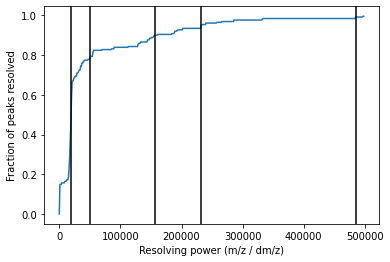

In [12]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_2.csv')

masterresults_df=masterresults_df[masterresults_df['Time']<25]
masterresults_df=masterresults_df[masterresults_df['Time']>3]

diff_summary=[]
res_summary=[]
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():
        result_sub=result[result['File']==file]

        #mzdiff=result_sub['m/z'].sort_values(ascending=True).diff().iloc[1:]
        #mzdiff_res=result_sub['m/z'].iloc[1:]/mzdiff
        differences=result_sub['m/z'].sort_values(ascending=True).diff()


        #Resolve from peaks on either side:
        mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
        mzdiff=mzdiff.min(axis=1)
        mzdiff_res=result_sub['m/z'].iloc[1:-1]/mzdiff*2

        diff_summary.extend(mzdiff.tolist())
        res_summary.extend(mzdiff_res[mzdiff_res<1e6].tolist())

res=list(range(10,int(max(res_summary)),1000))

count=[]
for i in res:
    count.append(len([element for element in res_summary if element<i])/len(res_summary))

print(len(diff_summary))
print(len([element for element in diff_summary if element<0.01]))
plt.plot(res,count)
for i in [0.5,0.8,0.9,0.95,0.99]:
    current=abs(np.array(count)-i).tolist()
    print(res[current.index(min(current))])
    plt.axvline(res[current.index(min(current))],color='black')
plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

#plt.hist(diff_summary, bins=50,range=[0,.03])
#plt.xlabel('m/z diff (Da)')
#plt.ylabel('frequency')
plt.show()



In [13]:
#Create a list of all unique features and describe their intensity. 

#Note, this line filters masterresults to only contain samples.
masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist.type=='sample'])]

#define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
uniquelist=[]
for time in masterresults_df.Time.unique():
    current=masterresults_df[masterresults_df.Time==time]
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique[currentunique['C']>1]
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in masterresults_df['File'].unique():
        current_file=current[current['File']==file].drop_duplicates(subset=['Molecular Formula'])
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniquelist=pd.concat(uniquelist,ignore_index=True)
print(len(uniquelist))


11341


9254


<AxesSubplot:xlabel='m/z', ylabel='m/z Error (ppm)'>

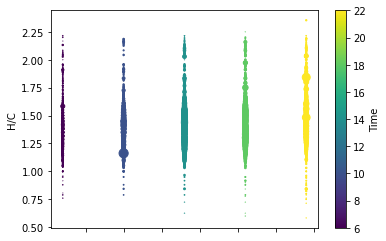

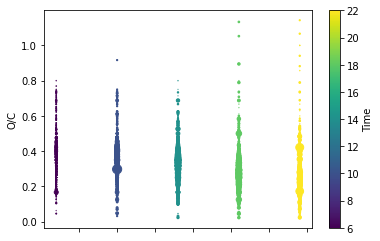

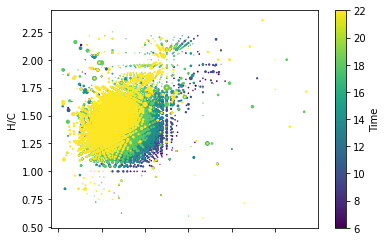

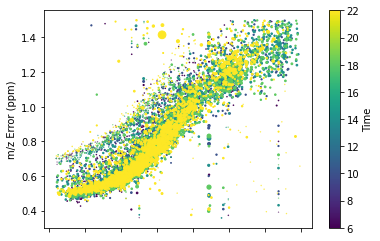

In [14]:
# Plot clean results. 

#uniquelist.fillna(0).plot.scatter('x_RMB_190828_TAB1_4.raw','x_RMB_190828_TAB2_5.raw')
results=uniquelist[(uniquelist['m/z Error (ppm)']>0.35) & (uniquelist['m/z Error (ppm)']<1.5) & (uniquelist['m/z']<900)]

#results=results.drop_duplicates(subset='Molecular Formula')
print(len(results))

results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

presults=results[results['Is Isotopologue']==0]
presults.plot.scatter(x='Time',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='Time',y='O/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='O/C',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='m/z',y='m/z Error (ppm)',s=presults['Peak Height']/4000,c='Time',cmap='viridis')



In [15]:
results['mol_class']='None'
results['mol_class'][results['N']<0.5]='CHO'
results['mol_class'][results['N']>0.5]='CHON'
results['mol_class'][(results['O/C']<0.6) & (results['H/C']>1.32) & (results['N/C']<0.126)]='Lipid'
results['mol_class'][(results['O/C']>0.12) & (results['O/C']<0.6) & (results['H/C']>0.9) & (results['H/C']<2.5) & (results['N/C']>0.126) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
results['mol_class'][(results['O/C']>0.6) & (results['O/C']<1) & (results['H/C']>1.2) & (results['H/C']<2.5) & (results['N/C']>0.2) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Amino Sugar'
results['mol_class'][(results['O/C']>0.8) & (results['H/C']>1.65) & (results['H/C']<2.7) & (results['N']<0.5)]='Carbohydrate'
results['mol_class'][(results['O/C']<1.15) & (results['H/C']<1.32) & (results['N/C']>0.07) & (results['N/C']<0.126)]='Phytochemical'
#results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Oxyaromatic'


Average Total: 6582.55
Unique good molecular formula #: 5655
Unique good molecular formula #: 4106
Unique m/z peaks: 10765


<AxesSubplot:xlabel='Time', ylabel='Peaks'>

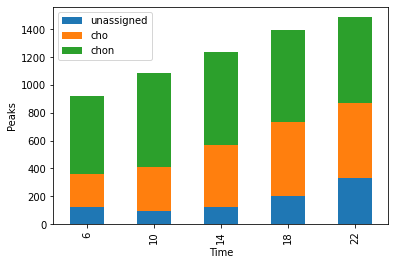

In [16]:

#Plot average number and classes of peaks assigned over time. 
nfiles=len(MSfiles)

#print(results.columns.values)
print('Average Total:', len(masterresults_df)/nfiles)
print('Unique good molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z Error (ppm)']>0.35) & (masterresults_df['m/z Error (ppm)']<1.5) & (masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

assign_summary=[]
for time in masterresults_df['Time'].unique():
    result=masterresults_df[(masterresults_df['Time']==time) & (masterresults_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    cho=len(result[(result['C']>1) & (result['N'].isnull())])/nfiles
    chon=len(result[result['N']>0])/nfiles
    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon'],stacked=True,ylabel='Peaks')


7665


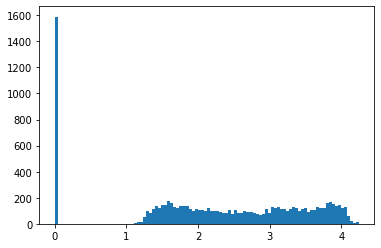

In [18]:
#Define RDOM
abundances=results[masterresults_df['File'].unique()].fillna(0)

df=abundances.mean(axis=1)
df_std=abundances.std(axis=1)

p_list=[]
for ind in abundances.index:
    p=max(abs(abundances.loc[ind]-df[ind]))/df_std[ind]
    if len(abundances.loc[ind][abundances.loc[ind]>1])<2:
        p=0
    p_list.append(p)

abundances['p']=p_list
results['p']=p_list

abundances=abundances[abundances['p']>0.1]
plt.hist(p_list,bins=100,range=[min(p_list),max(p_list)])

print(len(abundances))
abundances=abundances.sort_values(by='p',ascending=False)

#Generate clusters of ms features across depth.


In [19]:
from sklearn.cluster import AgglomerativeClustering
#match sample name with depth. 
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

results_clustered=results[results['p']>0.1]

norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)

norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)

#clustermethod='average'
clustermethod='ward'

#for column in norm_abundances:
#    current=norm_abundances[column]
#    norm_abundances[column]=current/max(current)

cluster = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)

results_clustered['cluster']=cluster.labels_

#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')

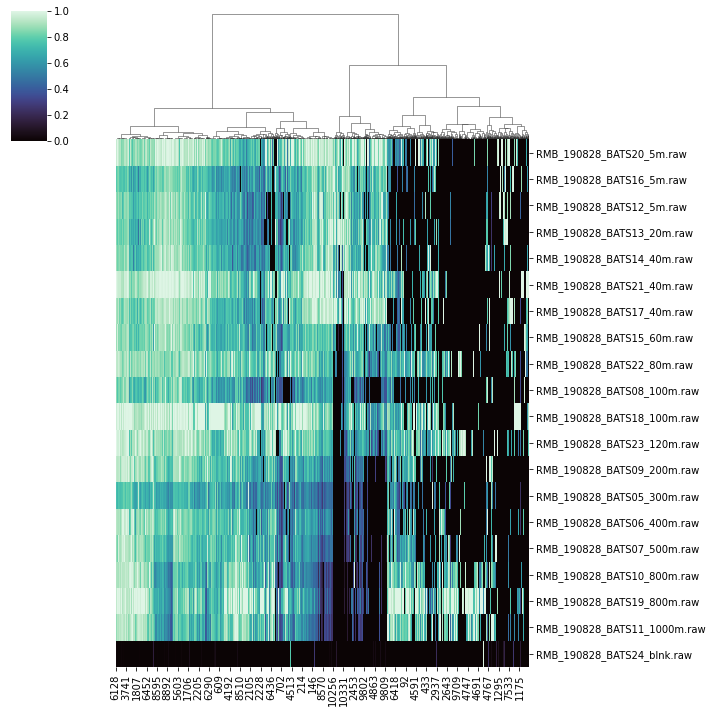

In [21]:
clustermethod='ward'

#match sample name with depth. 
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)


#profile=pd.DataFrame({'Depth':depth,'Abundance':abundances.iloc[9][:-1]})
#profile=profile.sort_values(by='Depth')

#plt.plot(profile.Abundance,profile.Depth)
#plt.ylim(1000,0)
clusterplot=norm_abundances
#clusterplot=clusterplot.drop(['p'],axis=1)
clusterplot=clusterplot.transpose()
clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()


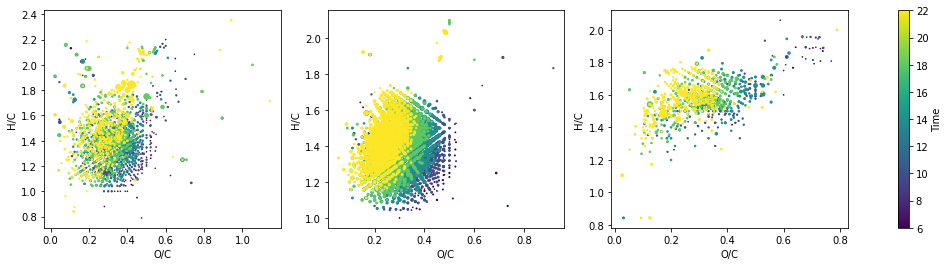

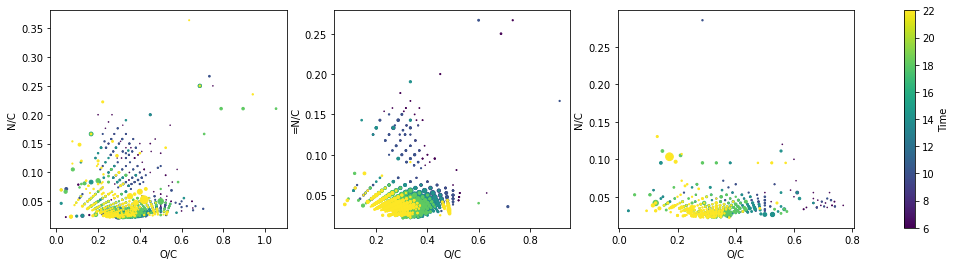

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='H/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='H/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='N/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='=N/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='N/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

plt.show()



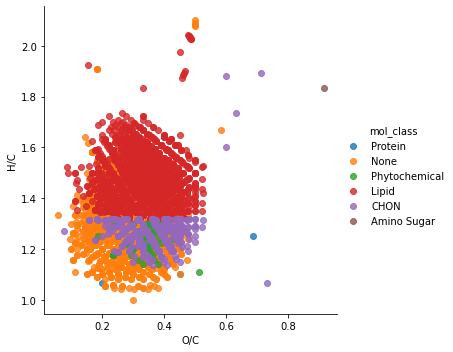

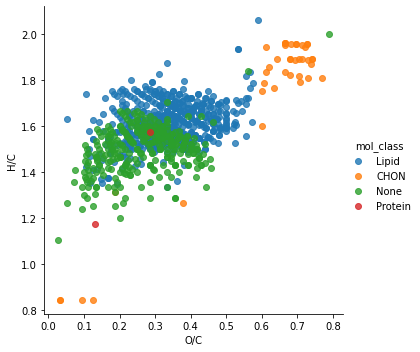

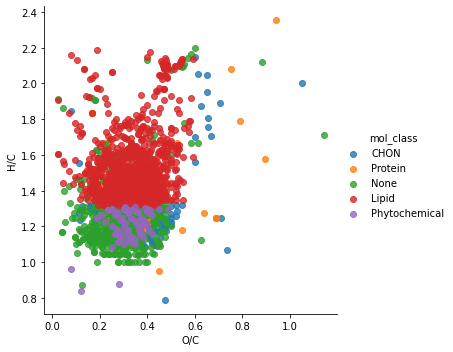

In [36]:
sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)], hue='mol_class', fit_reg=False)
sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)], hue='mol_class', fit_reg=False)
sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)], hue='mol_class', fit_reg=False)

plt.show()

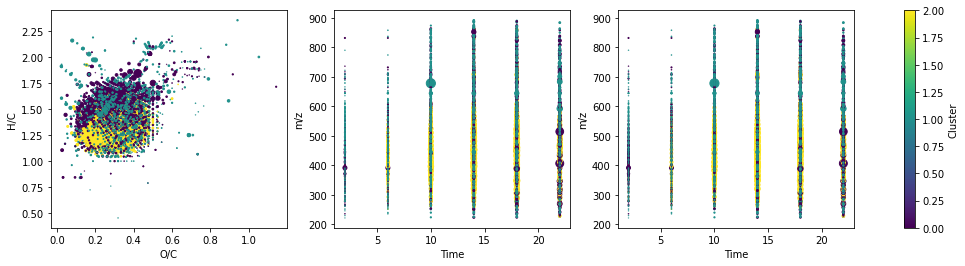

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
ax2.scatter(x=preresults['Time'],y=preresults['m/z'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax2.set(xlabel='Time',ylabel='m/z')
ax3.scatter(x=preresults['Time'],y=preresults['m/z'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax3.set(xlabel='Time',ylabel='m/z')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Cluster')



2634


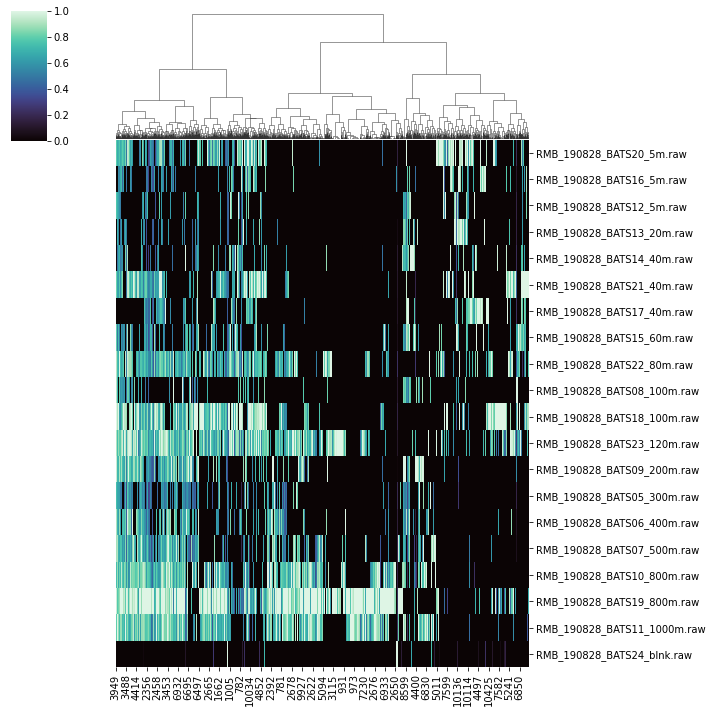

In [23]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==0]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method='ward')

plt.show()

4026


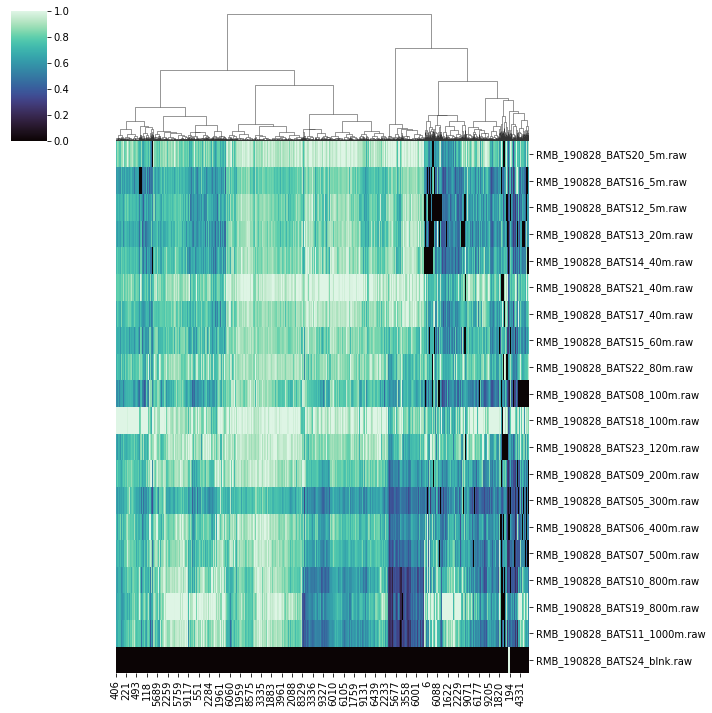

In [26]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==1]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method='ward')

plt.show()

1005


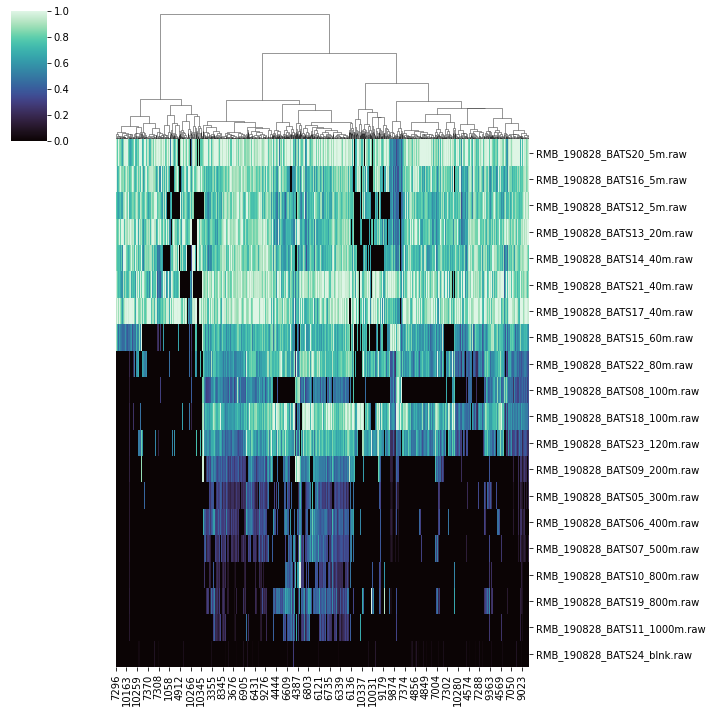

In [27]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==2]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()

print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method='ward')

plt.show()

In [39]:
#Profile plotter
depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

current=results_clustered['m/z'][1]

result=results_clustered.loc[2]
print(result)
intensity=result[result[masterresults_df['File'].unique()].fillna(0)]




stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

Unnamed: 0                                            554
Index                                                   3
m/z                                            263.127913
Calibrated m/z                                 263.127913
Calculated m/z                                 263.127786
Peak Height                                   1784.754552
Peak Area                                       -0.509606
Resolving Power                             941232.151752
S/N                                              2.490322
Ion Charge                                              1
m/z Error (ppm)                                   0.48393
m/z Error Score                                  0.958397
Isotopologue Similarity                               0.0
Confidence Score                                 0.575038
DBE                                                   7.0
H/C                                                   1.2
O/C                                              0.266667
Heteroatom Cla

KeyError: "None of [Float64Index([1784.7545519493283, 1561.6223326678105, 1568.4256097918787,\n              1799.7225654895344,   1496.72489782986,                0.0,\n                             0.0,                0.0,   1606.35814196944,\n                2003.62149226662, 1286.0396954293612, 1512.7447909924504,\n              2071.6302969601443,  2597.064346632557, 1172.8027773830302,\n              1495.0425142403865,  2114.995359006071, 1798.1292864244297,\n              2018.3757195476396,                0.0],\n             dtype='float64')] are in the [index]"

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()